In [125]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv
from scipy.stats import norm, binom, ks_2samp
from scipy import stats, linalg
import random
from decimal import Decimal
import pydtmc
from collections import Counter
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from tqdm.auto import tqdm

In [126]:
from ipynb.fs.full.BoringTM import *

In [127]:
## Base parameters
"""
LC = 1 ## Lobby Cost
T = 10 ## Tax
mF = 10 ## Mean Fee of Getting Caught
nPPL = 11
fR = .25
R = nPPL * fR # enforcement resources

LobH = [2] ## Lobby History, arbitrary preset
CatH = [1] ## Catch history, arbitrary preset
"""

'\nLC = 1 ## Lobby Cost\nT = 10 ## Tax\nmF = 10 ## Mean Fee of Getting Caught\nnPPL = 11\nfR = .25\nR = nPPL * fR # enforcement resources\n\nLobH = [2] ## Lobby History, arbitrary preset\nCatH = [1] ## Catch history, arbitrary preset\n'

In [128]:
def pSS1(LobH, CatH, nPPL, fR): #Gets probability of lobbying successfully, subjective
    t = len(LobH) - 1
    pss = 1 - ((.8+CatH[t]) / (1+LobH[t]))
    #print(pss)
    return pss

In [129]:
def pCat(LobH, nPPL, fR):  #Gets objective probability of success 
    R = nPPL * fR
    t = len(LobH) - 1
    if LobH[t] <= R:
        return .8
    else:
        return .8 * (R / LobH[t])

In [171]:
def it(LobH, CatH, LC, T, mF, nPPL, fR, fines):
    t = len(LobH)
    ps = pSS1(nPPL = nPPL, fR = fR, LobH = LobH, CatH = CatH)
    LobH.append(0)
    CatH.append(0)
    fines.append(0)
    for i in range(0,nPPL+1):
        ifine = np.random.normal(loc = mF, scale = 1)
        if -T < (ps * -LC) + ((1-ps) * (-T - LC - (ifine))):
            LobH[t] = LobH[t] + 1
            fines[t] = fines[t] + ifine
            
            
    for i in range(0,LobH[t]):
        if random.random() < pCat(nPPL = nPPL, fR = fR, LobH = LobH):
            CatH[t] = CatH[t] + 1
    
    return LobH, CatH, fines

In [131]:
def run(itr, LobH, CatH, LC, T, mF, nPPL, fR, fines):
    for i in tqdm(range(0,itr)):
        LobH, CatH, fines = it(LobH = LobH, CatH = CatH, LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, fines = fines)
    return LobH, CatH, fines

In [132]:
def set(LC, T, mF, nPPL, fR, itr, fines = []):
    LobH = [randint(0,nPPL)] ## Lobby History, arbitrary preset
    CatH = [randint(0,LobH[0])] ## Catch history, arbitrary preset
    fines = [CatH[0] * mF]
    LobH, CatH, fines = run(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr, LobH = LobH, CatH = CatH, fines = fines)
    return LobH, CatH, fines

In [133]:
LobH, CatH, fines = set(LC = 1, T = 5, mF = 2, nPPL = 100, fR = .5, itr = 1000)


100%|██████████| 1000/1000 [00:00<00:00, 4310.48it/s]


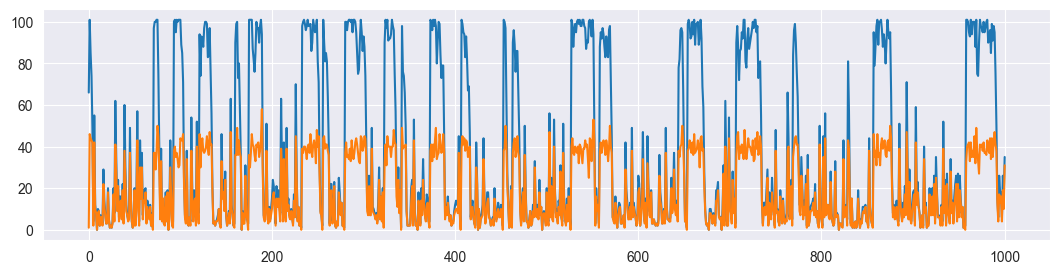

In [134]:
plt.figure(figsize=(13, 3)) 
plt.plot(LobH)
plt.plot(CatH)


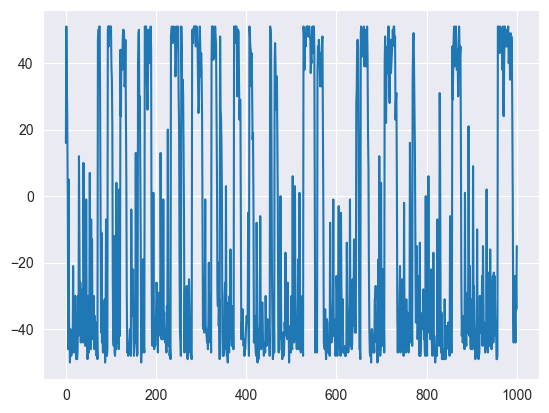

In [135]:
plt.plot([x - .5*100 for x in LobH])

In [136]:
def itrEF(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    EF = [(fR *nPPL) - (sum(set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0])/itr)]
    for i in range(2,int((1/bl)+1)):
        fR = i * bl
        EF.append((fR *nPPL) - (sum(set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0])/itr))
    return EF

100%|██████████| 1000/1000 [00:00<00:00, 5863.12it/s]


Text(0, 0.5, 'Average Excess Resources')

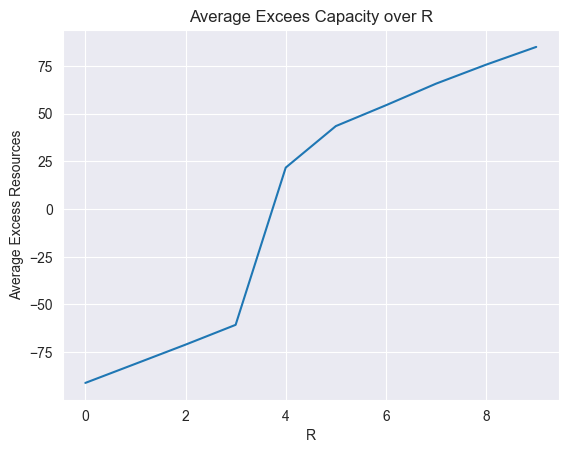

In [137]:
plt.plot(itrEF(LC = 1, T = 5, mF = 2, nPPL = 100, itr = 1000, bl = .1))
plt.title("Average Excees Capacity over R")
plt.xlabel("R")
plt.ylabel("Average Excess Resources")

In [138]:
def DynPDF(LC, T, mF, nPPL, fR, itr):
    MAXitr = itr
    itr = 10
    LobH, CatH, fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    count, bins_count = np.histogram(LobH, bins=nPPL+1)
    pdf2 = count / sum(count) 
    diff = 1

    while diff > .01 and itr <= MAXitr:
        itr = itr * 10
        pdf = pdf2
        LobH, CatH, fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
        count, bins_count = np.histogram(LobH, bins=nPPL+1)
        pdf2 = count / sum(count)
        diff = sum(abs(pdf - pdf2)) 
        n = 0
        while diff < .0001 and n < 4:
            n = n + 1
            LobH, CatH, fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
            count, bins_count = np.histogram(LobH, bins=nPPL+1)
            pdf2 = count / sum(count)
            diff = sum(abs(pdf - pdf2))
        #if itr >= MAXitr: break
    #cdf = np.cumsum(pdf) 
    #nL = range(0,nPPL+1) # equals to list(set(words))
    #Lfreq = [x/(len(LobH)) for x in list(Counter(LobH).values())] # counts the elements' frequency
    pdf = pdf2   
    print(f"Stationary at {itr} iterations")
    return pdf, bins_count

In [139]:
DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 10, itr = 100000)[0]

100%|██████████| 1000000/1000000 [00:29<00:00, 34268.77it/s]


Stationary at 1000000 iterations


array([0.11987288, 0.04211996, 0.01302499, 0.004745  , 0.002902  ,
       0.002066  , 0.00179   , 0.002913  , 0.00636899, 0.01111899,
       0.79307821])

In [140]:
DPDF = DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 30, itr = 1000)[0]
pBin = 0
for i in range(0,5+1):
    pBin = pBin + DPDF[i]
pBin

100%|██████████| 10000/10000 [00:00<00:00, 11856.01it/s]

Stationary at 10000 iterations


0.006999300069993002

In [141]:
def ConvTEST(LC, T, mF, nPPL, fR, itr):
       DPDF = DynPDF(fR = fR, LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr)[0]
       TMPDF = CollapsedSD(fR = fR, LC = LC, T = T, mF = mF, nPPL = nPPL)
       
       #plt.plot(DPDF, color="red", label="PDF")
       #plt.plot(TMPDF, color="green", label="SD")
       #plt.ylim([0, 1])
       
       print(DPDF)
       print(TMPDF)
       diff = sum(abs(DPDF - TMPDF))
       print(f"Differnece is : {diff}")
       if diff < .01: print("Yay")
       else: print("sucks to suck")

In [142]:
ConvTEST(LC = 1, T = 5, mF = 5, nPPL = 10, fR = .5, itr = 1000000)

100%|██████████| 100000/100000 [00:02<00:00, 42587.27it/s]


Stationary at 100000 iterations


100%|██████████| 66/66 [00:06<00:00, 10.13it/s]

[9.94400056e-01 4.60995390e-03 8.99991000e-05 1.09998900e-04
 1.39998600e-04 1.59998400e-04 2.49997500e-04 1.49998500e-04
 6.99993000e-05 9.99990000e-06 9.99990000e-06]
[9.99996479e-01 2.88867968e-06 3.36884411e-08 7.30602598e-08
 1.22696851e-07 1.45770119e-07 1.21432701e-07 7.02326260e-08
 2.86898498e-08 1.16675384e-08 2.47432650e-08]
Differnece is : 0.011192846678451905
sucks to suck


In [143]:
TMPDF = [.1,.2,.3,.2,.1,.1]
TMPDF2 = [.3,.2,.2,.1,.1,.1]
cdf = np.cumsum(TMPDF)
cdf
#stats.kstest(TMPDF, TMPDF2)
ks_2samp(TMPDF, TMPDF2)

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.1, statistic_sign=1)

In [144]:
def GraphDynPDF(LC, T, mF, nPPL, fR, itr):
    pdf, bins_count = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.ylim([0, 1])
    plt.legend()

100%|██████████| 100000/100000 [00:02<00:00, 43532.25it/s]


Stationary at 100000 iterations


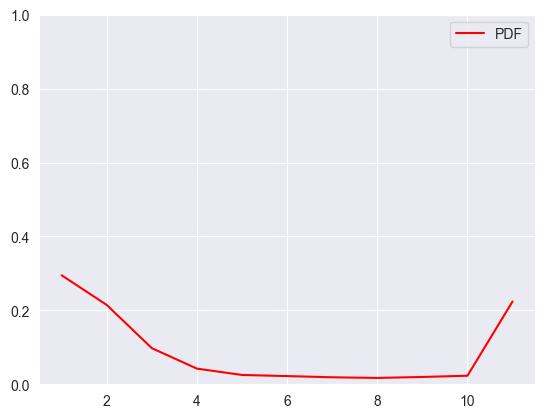

In [145]:
GraphDynPDF(LC = 1, T = 5, mF = 2, nPPL = 10, fR = .5, itr = 10000)

In [146]:
def DynItrR(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    RDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
    for i in range(2,int(1/bl+1)):
        fR = i * bl
        tRDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
        RDis = np.vstack([RDis, tRDis])
    return RDis

In [147]:
def GraphDynROut(LC, T, mF, nPPL, bl, itr):
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(0,nPPL+1)
    y = range(0,int(1/bl))

    data = DynItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr, bl = bl)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('nLobby')
    ha.set_ylabel('R')
    ha.set_zlabel('Probability')
    ha.set_title("3D Dynamic Disrobutions based on R")

    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 32846.83it/s]


Stationary at 10000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 36458.87it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 36278.49it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 37971.55it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 38871.82it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 40001.83it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 38702.72it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 41423.47it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 36392.97it/s]


Stationary at 100000 iterations


100%|██████████| 100000/100000 [00:02<00:00, 37341.30it/s]

Stationary at 100000 iterations


<Figure size 1000x1000 with 0 Axes>

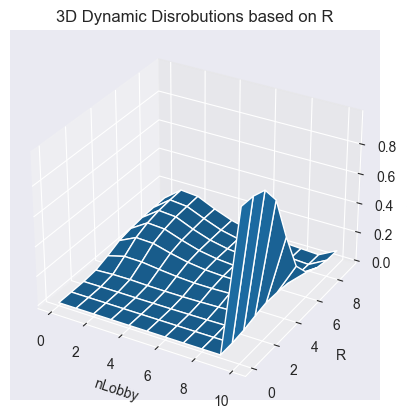

In [148]:
GraphDynROut(LC = 1, T = 5, mF = 1, nPPL = 10, bl = .1, itr = 10000)

In [178]:
def sc(nL, nC, nPPL, fR, T, fines):
    return ( (2 * nPPL * fR) + (T * nL) - ((fines + T) * nC) ) #- (T * (nPPL - nL))

In [150]:
def asc(fR, LC, T, mF, nPPL, itr):
    LobH, CatH, fines= set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    cost = sc(nL = sum(LobH) / len(LobH), nC = sum(CatH) / len(CatH), fines = sum(fines) / len(fines), T = T, nPPL = nPPL, fR = fR)
    return cost

In [151]:
def CostItrR(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    listcost = [asc(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)]
    for i in range(2,int(1/bl+1)):
        fR = i * bl
        listcost.append(asc(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr))
    return listcost

In [158]:
def MFItr(LC, T, nPPL, itr, step, bl):
    mF = step
    listMF = [CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr)]
    for i in range(2,int(10+1)):
        mF = i * step
        listMF.append(CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr))
    return listMF

In [159]:
def TItr(LC, mF, nPPL, itr, step, bl):
    T = step
    listT = [CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr)]
    for i in range(2,int(10+1)):
        T = i * step
        listT.append(CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr))
    return listT

In [160]:
def GraphMFitr(LC, T, nPPL, bl, step, itr):
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(1,10+1)
    y = range(1,10+1)

    data = MFItr(LC = LC, T = T, nPPL = nPPL, itr = itr, bl = bl, step = step)
    minMF = data.index(min(data))
    minR = data[minMF].index(min(data[minMF]))
    data = np.array(data)
    print(data)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('R')
    ha.set_ylabel('mF')
    ha.set_zlabel('Average Social Cost')
    ha.set_title(f"Minimum Avg. Social Cost: mf = {(minMF+1)*step:.2f}, R = {(minR+1)*(100*bl)}%")

    plt.show()

In [161]:
def GraphTitr(LC, mF, nPPL, bl, step, itr):
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(1,10+1)
    y = range(1,10+1)

    data = TItr(LC = LC, mF = mF, nPPL = nPPL, itr = itr, bl = bl, step = step)
    minT = data.index(min(data))
    minR = data[minT].index(min(data[minT]))
    data = np.array(data)
    print(data)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('R')
    ha.set_ylabel('T')
    ha.set_zlabel('Average Social Cost')
    ha.set_title(f"Minimum Avg. Social Cost: T = {(minT+1)*step:.2f}, R = {(minR+1)*(100*bl)}%")

    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 39117.21it/s]


100%|██████████| 1000/1000 [00:00<00:00, 60557.95it/s]


[[543.13865592 535.99692183 527.4851024  509.14067628 442.54985781
  351.59482172 292.68097053 244.96053949 252.24422097 245.58253522]
 [538.76603804 525.22064251 501.56015551 460.71050073 357.7415407
  261.45612383 207.3354607  188.62035564 184.7477493  182.76272666]
 [534.23642518 517.72151139 492.6728454  417.92622493 260.43671467
  191.29346595 162.81475688 149.14619164 142.20966964 134.49644455]
 [529.23956505 508.63277817 431.04917972 302.49299238 183.58775541
  129.72274705 114.26580785 112.77957785 103.32407961 102.44071259]
 [513.85879525 480.69514558 338.78346224 179.21852105 124.44513923
   87.16979155  76.95281281  80.41009653  72.57701855  73.90367319]
 [521.07128547 421.55633893 229.29542469 116.78770419  57.88156843
   63.03105311  52.43753194  47.15200645  48.52993908  42.88603194]
 [462.52637097 392.30463514 170.30546522  44.30240781  37.61325893
   33.27217234  29.49714314  28.3808664   28.57621098  29.35636037]
 [511.19962413 208.69799582  68.0228739   23.54327852  1

<Figure size 1000x1000 with 0 Axes>

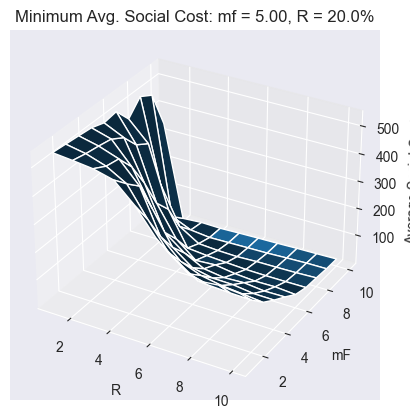

In [162]:
GraphMFitr(LC = 1, T = 5, nPPL = 10, bl = .1, step = .5, itr = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 57273.41it/s]

[[  2.98067737   4.98109013   6.89649998   8.9047257   10.95909863
   12.96312394  15.0400549   17.02345699  19.06519493  21.0080431 ]
 [  4.48326847   6.62675419   8.44396015  10.60148419  12.37941294
   14.23534513  16.28575866  18.53013304  20.4784463   22.2689942 ]
 [  8.80645212   8.97650947  10.42240585  12.71030359  14.71913578
   16.78267132  18.53310486  20.60812409  22.10307072  24.96616577]
 [ 49.75856508  15.51443929  13.5476786   16.75352433  18.11426956
   21.64496825  22.37820541  24.19567635  25.78398035  29.14311538]
 [226.80902702  61.04064183  20.885884    24.51415344  25.32019216
   26.73606495  26.5291781   30.07401968  33.93612377  35.28454492]
 [307.22708012 180.46287287  55.09716976  42.87221736  34.06289321
   36.87551552  35.91598765  40.66272386  41.59947636  42.29047375]
 [363.75780911 291.97457128 117.66582544  66.84331528  56.53716579
   54.30254227  56.54197435  51.89589833  55.32662003  55.73924874]
 [420.57659246 383.05521943 198.79280663 112.2459396   

<Figure size 1000x1000 with 0 Axes>

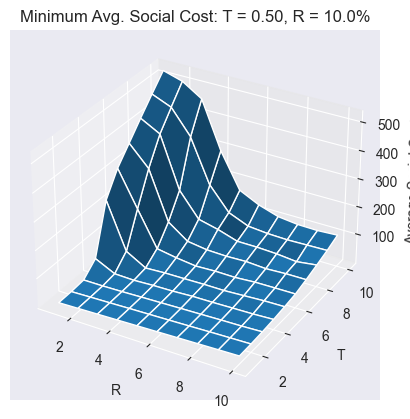

In [163]:
## We discover that the optimal level of T is always equal to the mF
GraphTitr(LC = 1, mF = 2, nPPL = 10, bl = .1, step = .5, itr = 1000)

In [176]:
def plotAvgSC(LC, mF, nPPL, bl, itr, T):
    listcost = CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr)
    plt.plot(range(int(100*bl),101, int(100*bl)), listcost)
    #plt.ylim(bottom = 0)
    plt.ylabel("Average Social Cost")
    plt.xlabel("% of people allocated to R")
    minLoc = (listcost.index(min(listcost))+1)
    print(minLoc)
    plt.title(f"The minimum avg. social cost ({min(listcost):.2f}) accures at R = {minLoc*(100*bl)}%, ER = {itrEF(LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr, bl = bl)[minLoc-1]}")

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 40189.03it/s]


5


100%|██████████| 10000/10000 [00:00<00:00, 44299.51it/s]


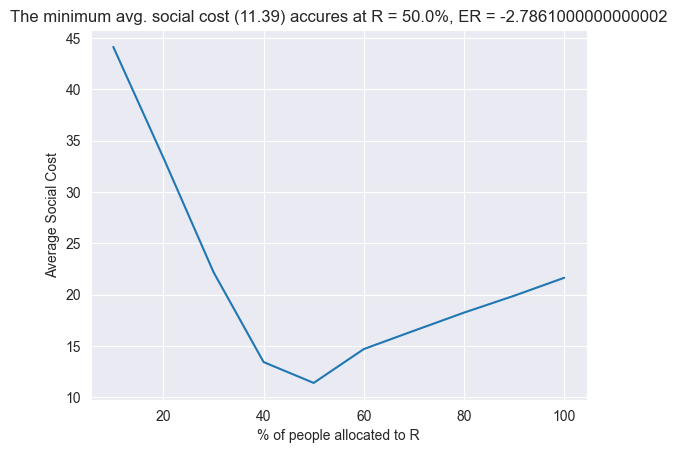

In [180]:
plotAvgSC(bl = .1, LC = 1, T = 5, mF = 1, nPPL = 10, itr = 10000)